# COGS 108 - Final Project 

# Overview

The NFL season usually starts in September and ends in February. Across the 17-week regular season and the playoffs afterwards, weather conditions at a team’s home stadium could change substantially. Furthermore, teams not only play at their home stadiums, but also have to travel to other regions in the country, possibly with very different climate, to play away games. Therefore, it is expected that teams will play under different weather conditions throughout the season. Knowing the relationship between team performance and weather conditions will be useful to NFL teams so that they may adopt different strategies under different weather conditions and hold special training sessions before playing at their least favorite weather conditions.  


# Names

- Annie Wai
- Chen Xu
- Christopher Yeh
- Ronak Sheth
- Shun Fujinami

- Yupei Zhou

# Group Members IDs

- A12944645
- A15720503
- A92086612
- A14255552
- A13636618
- A13410536

# Research Question

Our question is how does weather, with an emphasis on temperature, wind speed, and humidity affect the outcome of a National Football League (NFL) game. We will be analyzing the weather data during each NFL game, and finding a correlation between how well each team performs within given weather parameters.

## Background and Prior Work


There has been previous studies on how weather affects NFL games, even as far as betting lines being affected by the weather. According to Sports Betting Stats line-makers (bookies that determine the odds and payouts for betting on games) factor in temperature, precipitation, and wind speed when creating the betting odds. There has also been studies published by individuals based on data science which include “dome teams” (teams with an indoor stadium at home) playing in extreme weather, or the drop off of production by a quarterback in poor weather. Advanced Football Analytics analyzed data for when teams played in away stadiums and compared their home climate to the away climate. Most notably was “dome teams” not winning a single away game when the temperature was 20 degrees or lower. In another article Towards Data Science studied each quarterback’s statistics when playing in extreme weather. This article demonstrated a clear drop off in production of each quarterback when comparing their play in “great weather” versus “bad weather” Each of these previous studies narrowed down the data to specific scenarios, or a specific player’s position when analyzing the data. Our study will broaden the scope of how weather affects NFL games to every team, and every game in our dataset. This study will demonstrate how big a factor weather plays in determining the outcome of an NFL game in the grand scheme of all factors that play a part in winning an NFL game. 

References (include links): 
- 1) Sports Bettings Stats (https://www.sportsbettingstats.com/nfl/football-weather)
- 2) Advanced Football Analytics (http://archive.advancedfootballanalytics.com/2012/01/how-does-temperature-affect-road-teams.html)
- 3) Towards Data Science (https://towardsdatascience.com/football-weather-diving-into-the-effects-of-weather-on-nfl-qb-performance-f0edb420623d)

# Hypothesis


Our hypothesis to the question is that each team will have a preferred weather range in which they perform their best, and that weather range will be most similar to the average weather at their home stadium. 

# Dataset(s)


- Dataset Name: NFL scores and betting data
- Link to the dataset: https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data#spreadspoke_scores.csv
- Number of observations: 12400

This dataset includes 12,400 games since the 1966 season with 17 variables including: 
schedule date, schedule season, schedule week, schedule playoff, team home, score home, score away, team away, team favorite id, spread favorite, over under line, stadium, stadium neutral, weather temperature, weather wind mph, weather humidity, and extra weather detail.


# Setup


In [1]:
from scipy.stats import ttest_ind, chisquare, normaltest, ttest_1samp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning


We created a dataframe from the dataset csv file. We will drop the following unused columns: schedule season, schedule week, schedule playoff, stadium neutral, team favorite id, spread favorite, and over under line. We will also drop any games played indoors.

In [2]:
df = pd.read_csv("./nfl-scores-and-betting-data/spreadspoke_scores.csv")
df = df.drop(columns=["schedule_season", "schedule_week", "schedule_playoff", "stadium_neutral", 
                      "team_favorite_id", "spread_favorite", "over_under_line"],
             axis=1)
df = df[df.weather_detail != "DOME"]

Based on the score of the home and away team, we want to add a column to indicate the outcome of the game.

In [3]:
for index, row in df.iterrows():
    score_home = df.loc[index]['score_home']
    score_away = df.loc[index]['score_away']
    if score_home > score_away:
        df.at[index, 'home_w_l_t'] = 'WIN'
    elif score_away > score_home:
        df.at[index, 'home_w_l_t'] = 'LOSS'
    else:
        df.at[index, 'home_w_l_t'] = 'TIE'

It would appear that most entries are missing weather humidity and weather detail, so we are dropping rows without weather humidity and the whole column of weather detail.

In [4]:
df.dropna(subset=['weather_humidity'], inplace = True)
df = df.drop(columns = ['weather_detail'])
df.head()

,schedule_date,team_home,score_home,score_away,team_away,stadium,weather_temperature,weather_wind_mph,weather_humidity,home_w_l_t
0,09/02/1966,Miami Dolphins,14,23,Oakland Raiders,Orange Bowl,83.0,6.0,71,LOSS
1,09/03/1966,Houston Oilers,45,7,Denver Broncos,Rice Stadium,81.0,7.0,70,WIN
2,09/04/1966,San Diego Chargers,27,7,Buffalo Bills,Balboa Stadium,70.0,7.0,82,WIN
3,09/09/1966,Miami Dolphins,14,19,New York Jets,Orange Bowl,82.0,11.0,78,LOSS
4,09/10/1966,Green Bay Packers,24,3,Baltimore Colts,Lambeau Field,64.0,8.0,62,WIN


# Data Analysis & Results

We'll gather the temperature and wind speed data separately to visualize the outcome of the games based on temperature and wind speed.

In [5]:
temp_win = []
temp_tie = []
temp_loss = []
wind_win = []
wind_tie = []
wind_loss = []

for index, row in df.iterrows():
    if row["home_w_l_t"] == "WIN":
        temp_win.append(row["weather_temperature"])
        wind_win.append(row["weather_wind_mph"])
    elif row["home_w_l_t"] == "TIE":
        temp_tie.append(row["weather_temperature"])
        wind_tie.append(row["weather_wind_mph"])
    else:
        temp_loss.append(row["weather_temperature"])
        wind_loss.append(row["weather_wind_mph"])

We will graph histograms for game outcomes and temperature.

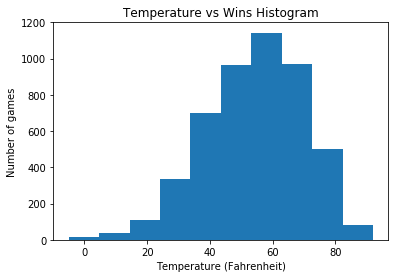

In [6]:
# temp_win histogram
plt.hist(df[df["home_w_l_t"] == "WIN"]["weather_temperature"])
plt.title("Temperature vs Wins Histogram")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Number of games")
plt.show()

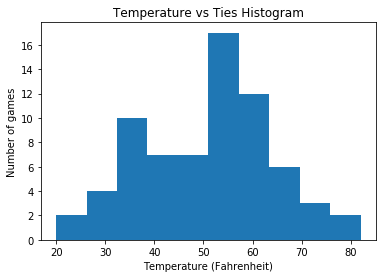

In [7]:
# temp_tie histogram
plt.hist(df[df["home_w_l_t"] == "TIE"]["weather_temperature"])
plt.title("Temperature vs Ties Histogram")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Number of games")
plt.show()

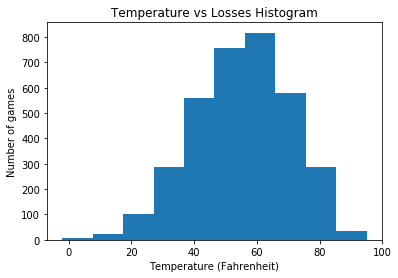

In [8]:
# temp_loss histogram
plt.hist(df[df["home_w_l_t"] == "LOSS"]["weather_temperature"])
plt.title("Temperature vs Losses Histogram")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Number of games")
plt.show()

From these three graphs we can compare the frequency of wins, losses, and ties within each temperature range. The temperature vs wins and temperature vs losses histograms are very similar, while the temperature vs ties histrogram shows and irregular distribution due to the small sample size.

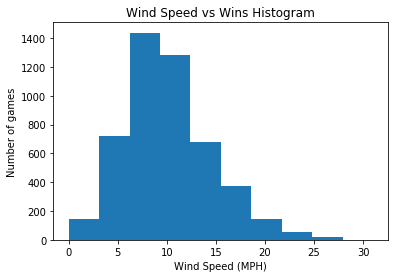

In [9]:
# wind_win histogram
plt.hist(df[df["home_w_l_t"] == "WIN"]["weather_wind_mph"])
plt.title("Wind Speed vs Wins Histogram")
plt.xlabel("Wind Speed (MPH)")
plt.ylabel("Number of games")
plt.show()

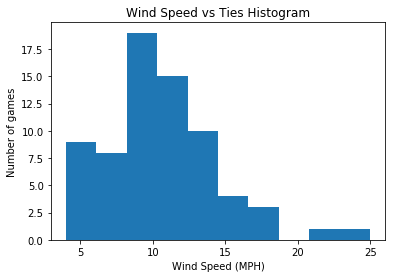

In [10]:
# wind_tie histogram
plt.hist(df[df["home_w_l_t"] == "TIE"]["weather_wind_mph"])
plt.title("Wind Speed vs Ties Histogram")
plt.xlabel("Wind Speed (MPH)")
plt.ylabel("Number of games")
plt.show()

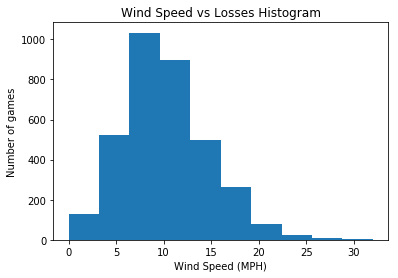

In [11]:
# wind_loss histogram
plt.hist(df[df["home_w_l_t"] == "LOSS"]["weather_wind_mph"])
plt.title("Wind Speed vs Losses Histogram")
plt.xlabel("Wind Speed (MPH)")
plt.ylabel("Number of games")
plt.show()

The wind speed vs the three outcomes of the games are also very similar; with the ties having an extremely small sample size again.

We want to see if there are any correlation with the outcome of the game based on the difference of temperature from their average home temperature. To do so, we add a column that stores the team's acclimated temperature. We then substract it by the current game's temperature.

In [12]:
df['avg_temperature'] = df.groupby(['team_home', 'home_w_l_t'])['weather_temperature'].transform(np.mean)
df['diff_temperature'] = df['avg_temperature'] - df['weather_temperature']
df.head()

,schedule_date,team_home,score_home,score_away,team_away,stadium,weather_temperature,weather_wind_mph,weather_humidity,home_w_l_t,avg_temperature,diff_temperature
0,09/02/1966,Miami Dolphins,14,23,Oakland Raiders,Orange Bowl,83.0,6.0,71,LOSS,76.254386,-6.745614
1,09/03/1966,Houston Oilers,45,7,Denver Broncos,Rice Stadium,81.0,7.0,70,WIN,79.000000,-2.000000
2,09/04/1966,San Diego Chargers,27,7,Buffalo Bills,Balboa Stadium,70.0,7.0,82,WIN,63.828877,-6.171123
3,09/09/1966,Miami Dolphins,14,19,New York Jets,Orange Bowl,82.0,11.0,78,LOSS,76.254386,-5.745614
4,09/10/1966,Green Bay Packers,24,3,Baltimore Colts,Lambeau Field,64.0,8.0,62,WIN,42.695652,-21.304348


Text(0, 0.5, 'Density')

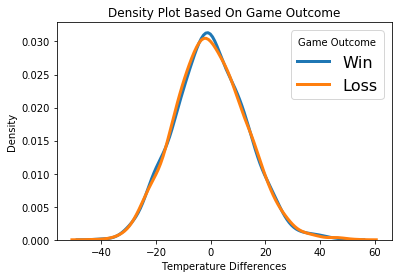

In [13]:
loss_temp = df.loc[df['home_w_l_t'] == 'LOSS']
win_temp = df.loc[df['home_w_l_t'] == 'WIN']

sns.distplot(loss_temp['diff_temperature'], hist = False, kde = True, kde_kws = {'linewidth': 3}, label = 'Win')
sns.distplot(win_temp['diff_temperature'], hist = False, kde = True, kde_kws = {'linewidth': 3}, label = 'Loss')

plt.legend(prop={'size': 16}, title = 'Game Outcome')
plt.title('Density Plot Based On Game Outcome')
plt.xlabel('Temperature Differences')
plt.ylabel('Density')

It appears that the two density plots of game outcome and temperature differences are very similar.

We perform a t-test to check if there is any statistically significant difference between **Temperature vs Wins** and **Temperature vs Losses**. We set the significance level 0.01. If there is a significant difference, then temperature might be useful in determining outcomes of the matches. As it turns out, there is a statistically significant difference, as the p-value is smaller than 0.01.

In [14]:
t_val_weather, p_val_weather = ttest_ind(temp_win, temp_loss)
print("Our t value is: ", t_val_weather)
print("Our p vlaue is: ", p_val_weather)

Our t value is:  -2.741049044299961
Our p vlaue is:  0.006137419103358492


We can carry out a similar t-test for wind speed. However, there is not a significant different between wind_win and wind_loss as the p-value is larger than 0.01. 

In [15]:
t_val_wind, p_val_wind = ttest_ind(wind_win, wind_loss)
print("Our t value is: ", t_val_wind)
print("Our p vlaue is: ", p_val_wind)

Our t value is:  1.4349573206864878
Our p vlaue is:  0.15133686599379564


We would like to predict the outcome of the matches based on home team, away team and weather temperature information. We can standarize all the temperatures based on the home team and the outcome of the matches. 

In [16]:
# Make a copy of df
df1 = df.copy()

First we can compute the average temperature of games with each of the three outcomes (WIN/LOSS/TIE) for each team.

The averages are saved as a new column '*avg_temperature*'

In [17]:
df1['avg_temperature'] = df1.groupby(['team_home', 'home_w_l_t'])['weather_temperature'].transform(np.mean)

Then we can compute the standard deviation of temperatue of games with each of the three outcomes (WIN/LOSS/TIE) for each team.

The standard deviations are saved as a new column '*std_temperature*'

In [18]:
df1['std_temperature'] = df1.groupby(['team_home', 'home_w_l_t'])['weather_temperature'].transform(np.std)

With average and standard deviation of each group already computed, we can proceed to compute the z-score.

The z-scores are saved as a new column '*z_score_temperature*'

In [19]:
df1['z_score_temperature'] = (df1['weather_temperature'] - df1['avg_temperature']) / df1['std_temperature']

In [20]:
df1[['team_home', 'weather_temperature', 'avg_temperature', 'std_temperature', 'z_score_temperature']].head()

,team_home,weather_temperature,avg_temperature,std_temperature,z_score_temperature
0,Miami Dolphins,83.0,76.254386,6.995335,0.964302
1,Houston Oilers,81.0,79.000000,2.828427,0.707107
2,San Diego Chargers,70.0,63.828877,7.095555,0.869717
3,Miami Dolphins,82.0,76.254386,6.995335,0.821349
4,Green Bay Packers,64.0,42.695652,16.134627,1.320412


For this step, we will predict the outcome only based on *team_home*, *team_away*, and *z_score_temperature*. <br>
Notice that there are some null values in the *z_score_temperature* column. The reason is that some teams only win/lose/tie one match at home, so the corresponding standard deviation of temperature would be 0. To account for this, we will input these null values with 0 since theoreticaly they are the same as the average. <br>
Furthermore, we drop tied matches because of the small sample size. <br>
Also we convert all WIN in the *home_w_l_t* columns with 1.0 and all LOSS in the *home_w_l_t* column with 0.0.

In [21]:
# Input data
classifier_data = df1[['team_home', 'team_away', 'z_score_temperature', 'home_w_l_t']].fillna(0)

# Drop ties
classifier_data = classifier_data.loc[classifier_data['home_w_l_t'] != 'TIE']

# Convert labels
classifier_data['home_w_l_t'] = classifier_data['home_w_l_t'].replace({'WIN': 1.0, 'LOSS': 0.0})

Split the data into training data (80% of all) and test data (20% of all)

In [22]:
X = classifier_data.drop('home_w_l_t', axis = 1)
y = classifier_data.home_w_l_t
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Preprocess the *team_home* and *team_away* columns by one hot encoding them.

In [23]:
# Initialize the preprocessor
onehot_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers = [('onehot', onehot_transformer, ['team_home', 'team_away'])], remainder = 'passthrough')

Use the Random Forest classifier. At this step, we do not specify any parameters in the classifier. Then fit the model and compute the predictions.

In [24]:
classifier = Pipeline([('preprocessor', preprocessor),('classifier', RandomForestClassifier())])

# Fit the model 
classifier.fit(X_train, y_train)

# Compute the predictions
preds = classifier.predict(X_test)

After we have the predictions, we can look at some statistics. <br>
The accuracy score measures the overall accuracy of the model and the accuracy score of our model is **55%**. <br>
The recall score measures the following: Among all the games which the home team wins, what proportions of them are correctly identified by our model. Our model correctly identifies **59%** of them. <br>
The recall score of negative class measures the following: Among all the games which the home team loses, what proportions of them are correctly identified by our model. Our model correctly identifies **49%** of them. <br>
The precision score measures the following: Among all the games that are predicted to be a home win by our model, what proportions of them are actually won by the home team. In our model, **63%** of the games that are predicted to be a home win by our model are actually won by the home team.

In [25]:
(metrics.accuracy_score(y_test, preds), # accuracy score
metrics.recall_score(y_test, preds), # recall score
metrics.recall_score(y_test, preds, pos_label = 0), # recall score of the negative class
metrics.precision_score(y_test, preds)) # precision score

(0.5637019230769231,
 0.6276150627615062,
 0.4774011299435028,
 0.6185567010309279)

We can do a grid search to see if changing some parameters in the Random Forest Classifier will result in a better accuracy score. 

In [26]:
# Some candidates for the paratemers.
parameters = {
    'classifier__max_depth': [10,20,30,40], 
    'classifier__min_samples_split':[2,4,7,10],
    'classifier__min_samples_leaf':[2,4,7,10]
}

# Use the grid search to search for the best paratemers with 3-fold cross validation
clf = GridSearchCV(classifier, parameters, scoring = 'accuracy', cv = 3)
clf.fit(X_train, y_train)
clf.best_params_

{'classifier__max_depth': 30,
 'classifier__min_samples_leaf': 4,
 'classifier__min_samples_split': 7}

Then we can build the Random Forest classifier with the grid searched parameters to see how much increase we gain in accuracy score.

In [27]:
classifier = Pipeline([('preprocessor', preprocessor),\
                       ('classifier', RandomForestClassifier(max_depth = clf.best_params_['classifier__max_depth'], \
                                                             min_samples_leaf = clf.best_params_['classifier__min_samples_split'], \
                                                             min_samples_split = clf.best_params_['classifier__min_samples_split']))])
classifier.fit(X_train, y_train)
preds = classifier.predict(X_test)

Indeed, there is an increase in accuracy score (55% to 60%). In terms of other statistics, there is a huge increase in recall_score (58% to 85%), meaning that the new model is much better at identifying home wins. However, an increase in some statistics result in an decrease in others. The new model has a much lower recall score of negative class (49% to 23%), which means the model is much worse at identifying home losses. There is also a slight decrease in precision score (63% to 62%). 

In [28]:
(metrics.accuracy_score(y_test, preds), # accuracy score
metrics.recall_score(y_test, preds), # recall score
metrics.recall_score(y_test, preds, pos_label = 0), # recall score of the negative class
metrics.precision_score(y_test, preds)) # precision score

(0.5757211538461539,
 0.8859832635983264,
 0.15677966101694915,
 0.5865650969529086)

For this part of our analysis we want to find out whether the average winning temperature of each team plays an role in the outcome of a game. 

To do this, we will have to get the average winning temperature for each team.

In [29]:
winning_temps = {}
# First we iterate through each entry of the dataframe, get the game temperature and save it as the value 
# under the winning team of the game
for index, row in df.iterrows():
    # only counting the winning temperature
    if row["home_w_l_t"] == "WIN":
        if row["team_home"] in winning_temps:
            winning_temps[row["team_home"]].append(row["weather_temperature"])
        else:
            winning_temps[row["team_home"]] = [row["weather_temperature"]]
    elif row["home_w_l_t"] == "LOSS":
        if row["team_away"] in winning_temps:
            winning_temps[row["team_away"]].append(row["weather_temperature"])
        else:
            winning_temps[row["team_away"]] = [row["weather_temperature"]]

# Now we loop through all teams in our winning_temps dictionary, and calculate the average winning 
# temperature of each team and save it in avg_winning_temp
avg_winning_temp = {}
for team in winning_temps.keys():
    total = 0
    for temp in winning_temps[team]:
        total += temp
    avg_winning_temp[team] = total / len(winning_temps[team])

After finding the Average Winning Temperature for each team, we will visualize the data by plotting each team's home stadium on a US map with points designating the average temperature they win in, relative to each other.

The map we create will be single color scale representation of temperature. Our method for determining the tint of red to use we set R to be 255 and G and B to be a value proprotionate to the temperature.

In [30]:
# After finding these values, we will visualize the data by plotting each team's home stadium
# on a US map with points designating the average temperature they win in, relative to each other.

# Get a value between 0-255 for G and B values for map visualization of avg winning temp
# R is 255, with RGB (255, 0, 0) representing the team with the hottest average winning temp
max = avg_winning_temp["Miami Dolphins"] # Temporary value
min = avg_winning_temp["Miami Dolphins"]
for temp in avg_winning_temp.values():
    if temp > max:
        max = temp
    if temp < min:
        min = temp
maxtiplier = 255 / max
mintiplier = 255 / (255 - 46.5 * maxtiplier)
avg_winning_temp_hex = {}
for key, value in avg_winning_temp.items():
    # G and B value between 0 and 255
    avg_winning_temp_hex[key] = round((255 - value * maxtiplier) * mintiplier)

After getting these RGB values, and putting data into a geoJSON file, we get the following map. The scale for this map is that the redder the pin, the hotter it is.

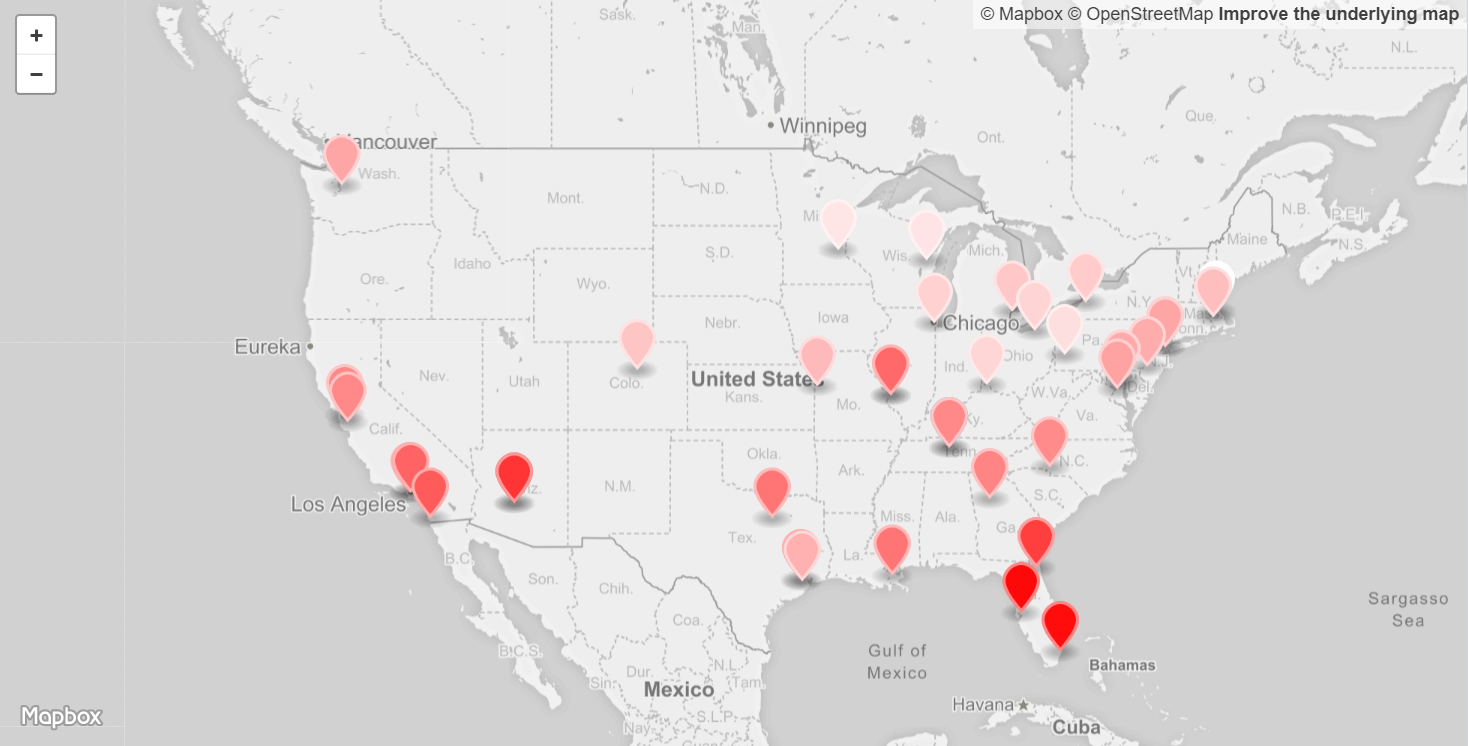

In [31]:
from IPython.display import Image 
Image(filename='map_resources/map_screenshot.png')

In the map of average winning temperatures for each team above there is a small correlation between the average temperature of a the team's location's climate. 

We can see that in warmer places, the Florida teams for example, they tend to have win in hotter temperatures than teams in colder climates.

This correlation is most likely primarily due to the fact that the teams in the colder climate play more games (at home) than they do at warmer cities skewing the average game temperature to lower temperatures and therefore the average winning game temperature to lower temperatures for colder cities.

As a result, this correlation is **not enough** to justify that teams perform better in their home cities' climate.

This could be a problem since there are 40+ teams but only 40 teams have winning records for now I will assume the teams not in the list to lose 100% of the time.

We will now implement a function to predict the outcome of a game based on each team's average winning temperature. The function will return True if the current temperature (game temperature) is closer to the home team's average winning temperature and False otherwise.

Note that we assume if two teams are equidistant to the game temperature, the home team will win due to home game advantage.

In [32]:
# function used to predict the outcome of a game based on each team's avg_winning_temp
# here we pass in the home_team name, away_team name, and the game temperature
# return True if game temperature is closer to home_team's avg_winning temperature
# False if otherwise, note that I assume if two teams are equally close to the winning temperature
# home_team should win due to home game advantage
def prediction(home_team, away_team, game_temp):
    home_diff = abs(avg_winning_temp[home_team] - game_temp)
    away_diff = abs(avg_winning_temp[away_team] - game_temp)
    if home_diff <= away_diff:
        return "WIN"
    else:
        return "LOSS"

To start testing our prediction model, we will choose the first game.

In [39]:
# pick game 0, Miami Dolphins vs Oakland Raiders, the actual result is loss
home_team = "Miami Dolphins"
away_team = "Oakland Raiders"
game_temp = 83.0
result = prediction(home_team, away_team, game_temp)
if result == "WIN":
    print("Prediction: Home team wins")
else:
    print("Prediction: Home team loses")

Prediction: Home team wins


Our prediction was the home team wins, but the home team actually lost. Our first test gave us the incorrect prediction. Regardless, we will loop through all the games and determine the accuracy of this method.

In [34]:
correct_count = 0
for index, row in df.iterrows():
    home_team = row["team_home"]
    away_team = row["team_away"]
    game_temp = row["weather_temperature"]
    if prediction(home_team, away_team, game_temp) == row["home_w_l_t"]:
        correct_count += 1
accuracy = correct_count / len(df)
print("Our accuracy is: ", accuracy)

Our accuracy is:  0.515855984740105


This method only has a **51%** accuracy a random result generator would give around 50% accuracy, so this approach does not seem to indicate average winning temperature and game result are related in anyway.

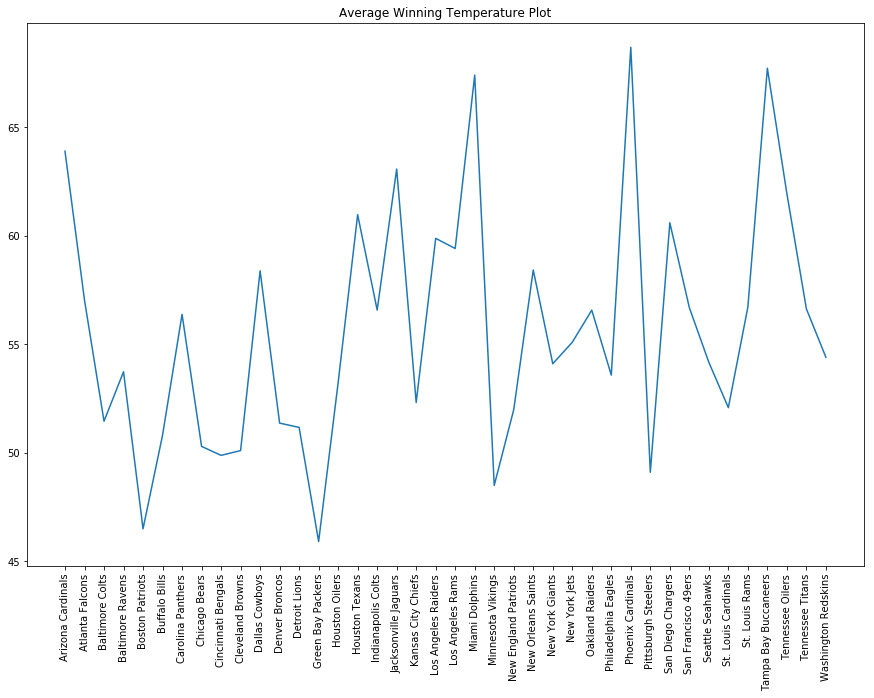

In [35]:
# plot the avg_winning_temp
lists = sorted(avg_winning_temp.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=(15,10))
plt.plot(x, y)
plt.xticks(rotation=90)
plt.title("Average Winning Temperature Plot")
plt.show()

For this part of our analysis, we will test if the overal win/loss record of each team determines the game result. Note that after we cleaned the dataframe, we are left with close to 9000 data entries, but we have 40+ teams so this implies majority of the teams on our record did not play every other team in the league. This would generate a huge hole in our prediction method. To counter this, we would calculate the the overall win rate of each team and use this data for our prediction when we run into the case where the two teams have no prior game record.

In [36]:
# here I will use a nested dictionary
# here I will also create a overall win count and total gams played count for each team
import collections 
win_ratio = {}
win_count = {}
team_list = set()
for index, row in df.iterrows():
    team_list.add(row["team_home"])
    team_list.add(row["team_away"])
total_count = collections.Counter(team_list)
for index, row in df.iterrows():
    team_won = team_lost = ""
    if row["home_w_l_t"] == "WIN":
        team_won = row["team_home"]
        team_lost = row["team_away"]
    elif row["home_w_l_t"] == "LOSS":
        team_won = row["team_away"]
        team_lost = row["team_home"]

    if team_won in win_ratio:
        if team_lost in win_ratio[team_won]:
            win_ratio[team_won][team_lost] += 1
        else:
            win_ratio[team_won][team_lost] = 0
    else:
        win_ratio[team_won] = {team_lost: 0}
    if team_won in win_count:
        win_count[team_won] += 1
    else:
        win_count[team_won] = 1
    total_count[team_won] += 1
    total_count[team_lost] += 1

We will now implement a function that takes two teams, and predicts the result based on win_ratio. If two teams never played with one another, we will use the overall win rate of each team and assume the team with higher overall win rate would win the game.

In [37]:
def predictWinRatio(team1, team2):
    if team1 in win_ratio and team2 in win_ratio:
            if team2 in win_ratio[team1]:
                # here we will have to take care of the equal case later, I just include it here
                if win_ratio[team1][team2] >= win_ratio[team2][team1]:
                    return team1
                else:
                    return team2
            else:
                return team1 if win_count[team1] / total_count[team1] >= win_count[team2] / total_count[team2] else team2
    else:
        if team1 not in win_ratio:
            print("team1 not in win_ratio")
        if team2 not in win_ratio:
            print("team2 not in win_ratio")

We will loop thorugh all the games and determine the accuracy of this method.

In [38]:
correct_count = 0
for index, row in df.iterrows():
    team_won = team_lost = ""
    if row["home_w_l_t"] == "WIN":
        team_won = row["team_home"]
        tem_lost = row["team_away"]
    elif row["home_w_l_t"] == "LOSS":
        team_won = row["team_away"]
        tem_lost = row["team_home"]
    if predictWinRatio(team_won, team_lost) == team_won:
        correct_count += 1
accuracy = correct_count / len(df)
print("Our accuracy is:", accuracy)

Our accuracy is: 0.5927515498330949


# Ethics and Privacy

We don’t have any privacy issues regarding this data as it was built from publicly available data published by the National Football League (NFL), as well as publicly available weather data from the National Oceanic and Atmospheric Administration (NOAA). There may be some potential biases in our dataset, mainly in the betting variables such as favorite id, spread favorite, and over under line. Since we did not use any of the betting data and the remaining variables that we did use are concrete numbers, we would not run into issues with biases in the data we’ve used. We do expect the national organizations to provide bias data such as game outcomes or weather data.

The ramifications of the results of this study could span to the population who places bets on the outcomes of NFL games, and this study could be used to predict unlikely outcomes. Our conclusion may possibly affect the betting odds that line-makers create. In addition to betting odds being affected, bet placers will also be affected by the findings of this study. Changes in the betting odds, as well as betting trends followed by bet placers can affect personal affairs regarding a person’s economic status. 

It is also important to consider the privacy and reputation of the sports teams analyzed, as negative attention to a team’s performance or brand may negatively affect their public opinion. As many people such as players, coaches, and reporters revolve their careers around NFL games, affecting the popularity of sports teams may negatively affect their careers. 

# Conclusion

Our analyses after creating both our histograms and prediction calculations were unfruitful in relation to our prediction. Our original hypothesis was that a stadium's humidity and wind speed had a factor in how the home team performed, but as it quickly showed no correlation in our histograms it was disregarded.

We then moved on to average winning temperature. It was promising, as there was a variety in the average winning temperature. However, on inspection of our plotted map, it was mostly just due to average temperature of a stadium in general, with warmer performing teams being more south in the U.S., and colder teams performing better in the north-east. This is not insignificant, however, as we could use this data to run prediction simulators to determine whether a team at an away game has a higher chance to win if the temperature is closer to their average winning temperature.

Running the simulator, we had a prediction rating of 51%, which was disappointing, as it was just flipping a coin. We discovered that many teams in the prediction we were running actually never played each other in our dataset. We altered it to just have the team with the higher win ratio win in that situation, and our prediction rating went up to 62%, which is also due to the fact that a better scoring team may just win regardless of weather.

So in conclusion, we have determined that average winning temperature is mostly irrelevant to the outcome of a game, and humidity and wind speed is also not particularly useful to determine the outcome of a game, pertaining to the number of game data we collected.

# Discussion

As even with more than 10,000 games played as data, as we consider there to be 41 distinct football teams, there were few games
played for each possible match-up, with some teams never even playing a match, and so our predictions, while significant, did not match with our original hypothesis.

This is also considering the fact that many teams had short-lived careers or changed their brand to another city or team name, which we could combine for more match-ups and therefore different outcomes for our predictions.


# Future Work

With more datasets and better distinguished teams, and we could also analyze other elements of game statistics, such as at what temperature injuries are more likely to occur, player fatigue and switching, and performance statistics of individual players.
Perhaps we can also use categorical data, such as whether it was raining or snowing, the frequency that
teams have experience in that condition, and their likeliness to win from that data.

There are also a large amount of variables that contribute to the outcome of an NFL game that we did not account for. Certain teams are favored to win against other teams within a particular season based on players they may have signed that year, or team dynamics such as coaching and strategy. These factors could be normalized for in a separate study in order to isolate weather as an independent variable.
